In [1]:
# Import libraries and modules
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.15.2-dlenv_tfe
1.18.1


# Local Development

## Arguments

In [2]:
arguments = {}
# File arguments
arguments["output_dir"] = "trained_model"

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 200
arguments["eval_steps"] = 100

# Eval parameters
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Image parameters
arguments["height"] = 32
arguments["width"] = 32
arguments["depth"] = 3

# Generator parameters
arguments["latent_size"] = 512
arguments["generator_projection_dims"] = [8, 8, 256]
arguments["generator_num_filters"] = [128, 64]
arguments["generator_kernel_sizes"] = [5, 5]
arguments["generator_strides"] = [1, 2]
arguments["generator_final_num_filters"] = 3
arguments["generator_final_kernel_size"] = 5
arguments["generator_final_stride"] = 2
arguments["generator_l1_regularization_scale"] = 0.01
arguments["generator_l2_regularization_scale"] = 0.01
arguments["generator_learning_rate"] = 0.00005
arguments["generator_optimizer"] = "Adam"
arguments["generator_clip_gradients"] = 5.0
arguments["generator_clip_weights"] = None
arguments["generator_train_steps"] = 1

# Critic hyperparameters
arguments["critic_num_filters"] = [64, 128]
arguments["critic_kernel_sizes"] = [5, 5]
arguments["critic_strides"] = [2, 2]
arguments["critic_dropout_rates"] = [0.3, 0.3]
arguments["critic_l1_regularization_scale"] = 0.01
arguments["critic_l2_regularization_scale"] = 0.01
arguments["critic_learning_rate"] = 0.00005
arguments["critic_optimizer"] = "RMSProp"
arguments["critic_clip_gradients"] = 5.0
arguments["critic_clip_weights"] = [-0.01, 0.01]
arguments["critic_train_steps"] = 5


## print_object.py

In [3]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))


## input.py

In [4]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\ndecode_example", "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )
    print_obj("decode_example", "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj("decode_example", "image", image)

    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj("decode_example", "image", image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)
    print_obj("decode_example", "label", label)

    return {"image": image}, label


def read_dataset(filename, mode, batch_size, params):
    """Reads CSV time series data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read CSV dataset
    using Dataset API, apply necessary preprocessing, and return an input
    function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.gfile.Glob(filename=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list, num_parallel_reads=40
        )

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.contrib.data.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=4
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(buffer_size=2)

        # Create a iterator, then get batch of features from example queue.
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn


## generator.py

In [5]:
def generator_network(Z, mode, params, reuse=False):
    """Creates generator network and returns generated output.

    Args:
        Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
        mode: tf.estimator.ModeKeys with values of either TRAIN, EVAL, or
            PREDICT.
        params: dict, user passed parameters.
        reuse: bool, whether to reuse variables or not.

    Returns:
        Generated outputs tensor of shape
            [cur_batch_size, height * width * depth].
    """
    # Create regularizer for dense layer kernel weights.
    regularizer = tf.contrib.layers.l1_l2_regularizer(
        scale_l1=params["generator_l1_regularization_scale"],
        scale_l2=params["generator_l2_regularization_scale"]
    )

    with tf.variable_scope("generator", reuse=reuse):
        # Project latent vectors.
        projection_height = params["generator_projection_dims"][0]
        projection_width = params["generator_projection_dims"][1]
        projection_depth = params["generator_projection_dims"][2]

        # shape = (
        #     cur_batch_size,
        #     projection_height * projection_width * projection_depth
        # )
        projection = tf.layers.dense(
            inputs=Z,
            units=projection_height * projection_width * projection_depth,
            activation=tf.nn.leaky_relu,
            name="projection_layer"
        )
        print_obj("generator_network", "projection", projection)

        # shape = (
        #     cur_batch_size,
        #     projection_height * projection_width * projection_depth
        # )
        projection_batch_norm = tf.layers.batch_normalization(
            inputs=projection,
            training=(mode == tf.estimator.ModeKeys.TRAIN),
            name="projection_batch_norm"
        )
        print_obj(
            "generator_network",
            "projection_batch_norm",
            projection_batch_norm
        )

        # Reshape projection into "image".
        # shape = (
        #     cur_batch_size,
        #     projection_height,
        #     projection_width,
        #     projection_depth
        # )
        network = tf.reshape(
            tensor=projection_batch_norm,
            shape=[-1, projection_height, projection_width, projection_depth],
            name="projection_reshaped"
        )
        print_obj("generator_network", "network", network)

        # Iteratively build upsampling layers.
        for i in range(len(params["generator_num_filters"])):
            # Add convolutional transpose layers with given params per layer.
            # shape = (
            #     cur_batch_size,
            #     generator_kernel_sizes[i - 1] * generator_strides[i],
            #     generator_kernel_sizes[i - 1] * generator_strides[i],
            #     generator_num_filters[i]
            # )
            network = tf.layers.conv2d_transpose(
                inputs=network,
                filters=params["generator_num_filters"][i],
                kernel_size=params["generator_kernel_sizes"][i],
                strides=params["generator_strides"][i],
                padding="same",
                activation=tf.nn.leaky_relu,
                use_bias=False,
                kernel_regularizer=regularizer,
                name="layers_conv2d_tranpose_{}".format(i)
            )
            print_obj("generator_network", "network", network)

            # Add batch normalization to keep the inputs from blowing up.
            network = tf.layers.batch_normalization(
                inputs=network,
                training=(mode == tf.estimator.ModeKeys.TRAIN),
                name="layers_batch_norm_{}".format(i)
            )
            print_obj("generator_network", "network", network)

        # Final conv2d transpose layer for image output.
        # shape = (cur_batch_size, height * width * depth)
        generated_outputs = tf.layers.conv2d_transpose(
                inputs=network,
                filters=params["generator_final_num_filters"],
                kernel_size=params["generator_final_kernel_size"],
                strides=params["generator_final_stride"],
                padding="same",
                activation=tf.nn.tanh,
                use_bias=False,
                kernel_regularizer=regularizer,
                name="layers_conv2d_tranpose_generated_outputs"
        )
        print_obj("generator_network", "generated_outputs", generated_outputs)

    return generated_outputs


def get_generator_loss(generated_logits):
    """Gets generator loss.

    Args:
        generated_logits: tensor, shape of
            [cur_batch_size, height * width * depth].

    Returns:
        Tensor of generator's total loss of shape [].
    """
    # Calculate base generator loss.
    generator_loss = -tf.reduce_mean(
        input_tensor=generated_logits,
        name="generator_loss"
    )
    print_obj(
        "\nget_generator_loss",
        "generator_loss",
        generator_loss
    )

    # Get regularization losses.
    generator_regularization_loss = tf.losses.get_regularization_loss(
        scope="generator",
        name="generator_regularization_loss"
    )
    print_obj(
        "get_generator_loss",
        "generator_regularization_loss",
        generator_regularization_loss
    )

    # Combine losses for total losses.
    generator_total_loss = tf.math.add(
        x=generator_loss,
        y=generator_regularization_loss,
        name="generator_total_loss"
    )
    print_obj(
        "get_generator_loss", "generator_total_loss", generator_total_loss
    )

    return generator_total_loss


## critic.py

In [6]:
def critic_network(X, params, reuse=False):
    """Creates critic network and returns logits.

    Args:
        X: tensor, image tensors of shape
            [cur_batch_size, height, width, depth].
        params: dict, user passed parameters.
        reuse: bool, whether to reuse variables or not.

    Returns:
        Logits tensor of shape [cur_batch_size, 1].
    """
    # Create the input layer to our DNN.
    # shape = (cur_batch_size, height * width * depth)
    network = X
    print_obj("\ncritic_network", "network", network)

    # Create regularizer for dense layer kernel weights.
    regularizer = tf.contrib.layers.l1_l2_regularizer(
        scale_l1=params["critic_l1_regularization_scale"],
        scale_l2=params["critic_l2_regularization_scale"]
    )

    with tf.variable_scope("critic", reuse=reuse):
        # Iteratively build downsampling layers.
        for i in range(len(params["critic_num_filters"])):
            # Add convolutional transpose layers with given params per layer.
            # shape = (
            #     cur_batch_size,
            #     critic_kernel_sizes[i - 1] / critic_strides[i],
            #     critic_kernel_sizes[i - 1] / critic_strides[i],
            #     critic_num_filters[i]
            # )
            network = tf.layers.conv2d(
                inputs=network,
                filters=params["critic_num_filters"][i],
                kernel_size=params["critic_kernel_sizes"][i],
                strides=params["critic_strides"][i],
                padding="same",
                activation=tf.nn.leaky_relu,
                kernel_regularizer=regularizer,
                name="layers_conv2d_{}".format(i)
            )
            print_obj("critic_network", "network", network)

            # Add some dropout for better regularization and stability.
            network = tf.layers.dropout(
                inputs=network,
                rate=params["critic_dropout_rates"][i],
                name="layers_dropout_{}".format(i)
            )
            print_obj("critic_network", "network", network)

        # Flatten network output.
        # shape = (
        #     cur_batch_size,
        #     (critic_kernel_sizes[-2] / critic_strides[-1]) ** 2 * critic_num_filters[-1]
        # )
        network_flat = tf.layers.Flatten()(inputs=network)
        print_obj("critic_network", "network_flat", network_flat)

        # Final linear layer for logits.
        # shape = (cur_batch_size, 1)
        logits = tf.layers.dense(
            inputs=network_flat,
            units=1,
            activation=None,
            kernel_regularizer=regularizer,
            name="layers_dense_logits"
        )
        print_obj("critic_network", "logits", logits)

    return logits


def get_critic_loss(generated_logits, real_logits):
    """Gets critic loss.

    Args:
        generated_logits: tensor, shape of
            [cur_batch_size, height * width * depth].
        real_logits: tensor, shape of
            [cur_batch_size, height * width * depth].

    Returns:
        Tensor of critic's total loss of shape [].
    """
    # Calculate base critic loss.
    critic_real_loss = tf.reduce_mean(
        input_tensor=real_logits,
        name="critic_real_loss"
    )
    print_obj(
        "\nget_critic_loss",
        "critic_real_loss",
        critic_real_loss
    )

    critic_generated_loss = tf.reduce_mean(
        input_tensor=generated_logits,
        name="critic_generated_loss"
    )
    print_obj(
        "get_critic_loss",
        "critic_generated_loss",
        critic_generated_loss
    )

    critic_loss = tf.add(
        x=critic_real_loss, y=-critic_generated_loss,
        name="critic_loss"
    )
    print_obj(
        "get_critic_loss",
        "critic_loss",
        critic_loss
    )

    # Get regularization losses.
    critic_regularization_loss = tf.losses.get_regularization_loss(
        scope="critic",
        name="critic_regularization_loss"
    )
    print_obj(
        "get_critic_loss",
        "critic_regularization_loss",
        critic_regularization_loss
    )

    # Combine losses for total losses.
    critic_total_loss = tf.math.add(
        x=critic_loss,
        y=critic_regularization_loss,
        name="critic_total_loss"
    )
    print_obj(
        "get_critic_loss",
        "critic_total_loss",
        critic_total_loss
    )

    return critic_total_loss


## wgan.py

In [7]:
def train_network(loss, global_step, params, scope):
    """Trains network and returns loss and train op.

    Args:
        loss: tensor, shape of [].
        global_step: tensor, the current training step or batch in the
            training loop.
        params: dict, user passed parameters.
        scope: str, the variables that to train.

    Returns:
        Loss tensor and training op.
    """
    # Create optimizer map.
    optimizers = {
        "Adam": tf.train.AdamOptimizer,
        "Adadelta": tf.train.AdadeltaOptimizer,
        "AdagradDA": tf.train.AdagradDAOptimizer,
        "Adagrad": tf.train.AdagradOptimizer,
        "Ftrl": tf.train.FtrlOptimizer,
        "GradientDescent": tf.train.GradientDescentOptimizer,
        "Momentum": tf.train.MomentumOptimizer,
        "ProximalAdagrad": tf.train.ProximalAdagradOptimizer,
        "ProximalGradientDescent": tf.train.ProximalGradientDescentOptimizer,
        "RMSProp": tf.train.RMSPropOptimizer
    }

    # Get gradients.
    gradients = tf.gradients(
        ys=loss,
        xs=tf.trainable_variables(scope=scope),
        name="{}_gradients".format(scope)
    )

    # Clip gradients.
    if params["{}_clip_gradients".format(scope)]:
        gradients, _ = tf.clip_by_global_norm(
            t_list=gradients,
            clip_norm=params["{}_clip_gradients".format(scope)],
            name="{}_clip_by_global_norm_gradients".format(scope)
        )

    # Zip back together gradients and variables.
    grads_and_vars = zip(gradients, tf.trainable_variables(scope=scope))

    # Get optimizer and instantiate it.
    optimizer = optimizers[params["{}_optimizer".format(scope)]](
        learning_rate=params["{}_learning_rate".format(scope)]
    )

    # Create train op by applying gradients to variables and incrementing
    # global step.
    train_op = optimizer.apply_gradients(
        grads_and_vars=grads_and_vars,
        global_step=global_step,
        name="{}_apply_gradients".format(scope)
    )

    if params["{}_clip_weights".format(scope)]:
        clipped_weight_vars = [
            tf.clip_by_value(
                t=tensor,
                clip_value_min=params["{}_clip_weights".format(scope)][0],
                clip_value_max=params["{}_clip_weights".format(scope)][1],
                name="{}_clip_by_value_weights".format(scope)
            )
            for tensor in tf.trainable_variables(scope=scope)
        ]

        with tf.control_dependencies(control_inputs=clipped_weight_vars):
            return loss, train_op
    return loss, train_op


def wgan_model(features, labels, mode, params):
    """Wasserstein GAN custom Estimator model function.

    Args:
        features: dict, keys are feature names and values are feature tensors.
        labels: tensor, label data.
        mode: tf.estimator.ModeKeys with values of either TRAIN, EVAL, or
            PREDICT.
        params: dict, user passed parameters.

    Returns:
        Instance of `tf.estimator.EstimatorSpec` class.
    """
    print_obj("\nwgan_model", "features", features)
    print_obj("wgan_model", "labels", labels)
    print_obj("wgan_model", "mode", mode)
    print_obj("wgan_model", "params", params)

    # Loss function, training/eval ops, etc.
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None

    if mode == tf.estimator.ModeKeys.PREDICT:
        # Extract given latent vectors from features dictionary.
        Z = tf.cast(x=features["Z"], dtype=tf.float32)

        # Get predictions from generator.
        generated_images = generator_network(Z, mode, params, reuse=False)

        # Create predictions dictionary.
        predictions_dict = {
            "generated_images": generated_images
        }

        # Create export outputs.
        export_outputs = {
            "predict_export_outputs": tf.estimator.export.PredictOutput(
                outputs=predictions_dict)
        }
    else:
        # Extract image from features dictionary.
        X = features["image"]

        # Get dynamic batch size in case of partial batch.
        cur_batch_size = tf.shape(
            input=X,
            out_type=tf.int32,
            name="wgan_model_cur_batch_size"
        )[0]

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[cur_batch_size, params["latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Establish generator network subgraph.
        generator_outputs = generator_network(Z, mode, params, reuse=False)

        # Establish critic network subgraph.
        real_logits = critic_network(X, params, reuse=False)

        # Get generated logits too.
        generated_logits = critic_network(
            generator_outputs, params, reuse=True
        )

        # Get generator total loss.
        generator_total_loss = get_generator_loss(generated_logits)

        # Get critic total loss.
        critic_total_loss = get_critic_loss(
            generated_logits, real_logits
        )

        if mode == tf.estimator.ModeKeys.TRAIN:
            # Get global step.
            global_step = tf.train.get_global_step()

            # Determine if it is time to train generator or critic.
            cycle_step = tf.mod(
                x=global_step,
                y=tf.cast(
                    x=tf.add(
                        x=params["generator_train_steps"],
                        y=params["critic_train_steps"]
                    ),
                    dtype=tf.int64
                )
            )

            # Create choose generator condition.
            condition = tf.less(
                x=cycle_step, y=params["generator_train_steps"]
            )

            # Needed for batch normalization, but has no effect otherwise.
            update_ops = tf.get_collection(key=tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(control_inputs=update_ops):
                # Conditionally choose to train generator or critic.
                loss, train_op = tf.cond(
                    pred=condition,
                    true_fn=lambda: train_network(
                        loss=generator_total_loss,
                        global_step=global_step,
                        params=params,
                        scope="generator"
                    ),
                    false_fn=lambda: train_network(
                        loss=critic_total_loss,
                        global_step=global_step,
                        params=params,
                        scope="critic"
                    )
                )
        else:
            loss = critic_total_loss

            # Concatenate critic logits and labels.
            critic_logits = tf.concat(
                values=[real_logits, generated_logits],
                axis=0,
                name="critic_concat_logits"
            )

            critic_labels = tf.concat(
                values=[
                    tf.ones_like(tensor=real_logits),
                    tf.zeros_like(tensor=generated_logits)
                ],
                axis=0,
                name="critic_concat_labels"
            )

            # Calculate critic probabilities.
            critic_probabilities = tf.nn.sigmoid(
                x=critic_logits, name="critic_probabilities"
            )

            # Create eval metric ops dictionary.
            eval_metric_ops = {
                "accuracy": tf.metrics.accuracy(
                    labels=critic_labels,
                    predictions=critic_probabilities,
                    name="wgan_model_accuracy"
                ),
                "precision": tf.metrics.precision(
                    labels=critic_labels,
                    predictions=critic_probabilities,
                    name="wgan_model_precision"
                ),
                "recall": tf.metrics.recall(
                    labels=critic_labels,
                    predictions=critic_probabilities,
                    name="wgan_model_recall"
                ),
                "auc_roc": tf.metrics.auc(
                    labels=critic_labels,
                    predictions=critic_probabilities,
                    num_thresholds=200,
                    curve="ROC",
                    name="wgan_model_auc_roc"
                ),
                "auc_pr": tf.metrics.auc(
                    labels=critic_labels,
                    predictions=critic_probabilities,
                    num_thresholds=200,
                    curve="PR",
                    name="wgan_model_auc_pr"
                )
            }

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs=export_outputs
    )


## serving.py

In [8]:
def serving_input_fn(params):
    """Serving input function.

    Args:
        params: dict, user passed parameters.

    Returns:
        ServingInputReceiver object containing features and receiver tensors.
    """
    # Create placeholders to accept data sent to the model at serving time.
    # shape = (batch_size,)
    feature_placeholders = {
        "Z": tf.placeholder(
            dtype=tf.float32,
            shape=[None, params["latent_size"]],
            name="serving_input_placeholder_Z"
        )
    }

    print_obj(
        "serving_input_fn",
        "feature_placeholders",
        feature_placeholders
    )

    # Create clones of the feature placeholder tensors so that the SavedModel
    # SignatureDef will point to the placeholder.
    features = {
        key: tf.identity(
            input=value,
            name="serving_input_fn_identity_placeholder_{}".format(key)
        )
        for key, value in feature_placeholders.items()
    }

    print_obj(
        "serving_input_fn",
        "features",
        features
    )

    return tf.estimator.export.ServingInputReceiver(
        features=features, receiver_tensors=feature_placeholders
    )


## model.py

In [9]:
def train_and_evaluate(args):
    """Trains and evaluates custom Estimator model.

    Args:
        args: dict, user passed parameters.

    Returns:
        `Estimator` object.
    """
    # Set logging to be level of INFO.
    tf.logging.set_verbosity(tf.logging.INFO)

    # Create our custom estimator using our model function.
    estimator = tf.estimator.Estimator(
        model_fn=wgan_model,
        model_dir=args["output_dir"],
        params=args
    )

    # Create train spec to read in our training data.
    train_spec = tf.estimator.TrainSpec(
        input_fn=read_dataset(
            filename="data/train.tfrecord",
            mode=tf.estimator.ModeKeys.TRAIN,
            batch_size=args["train_batch_size"],
            params=args
        ),
        max_steps=args["train_steps"]
    )

    # Create exporter to save out the complete model to disk.
    exporter = tf.estimator.LatestExporter(
        name="exporter",
        serving_input_receiver_fn=lambda: serving_input_fn(args)
    )

    # Create eval spec to read in our validation data and export our model.
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename="data/test.tfrecord",
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args
        ),
        steps=args["eval_steps"],
        start_delay_secs=args["start_delay_secs"],
        throttle_secs=args["throttle_secs"],
        exporters=exporter
    )

    # Create train and evaluate loop to train and evaluate our estimator.
    tf.estimator.train_and_evaluate(
        estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)

    return estimator


## Run model

In [10]:
shutil.rmtree(path=arguments["output_dir"], ignore_errors=True)
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fec3d6a1ed0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tens

## Prediction

In [11]:
!ls trained_model/export/exporter

1590989985


In [12]:
predict_fn = tf.contrib.predictor.from_saved_model(
    "trained_model/export/exporter/1590989985"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from trained_model/export/exporter/1590989985/variables/variables


Convert image back to the original scale.

In [13]:
generated_images = np.clip(
    a=((predictions["generated_images"] + 1.0) * (255. / 2)).astype(np.int32),
    a_min=0,
    a_max=255
)

In [14]:
print(generated_images.shape)

(500, 32, 32, 3)


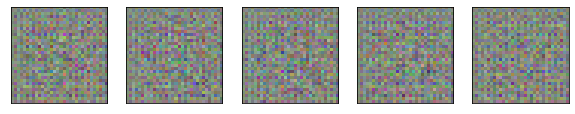

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i], cmap=plt.cm.binary)
plt.show()